In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from PIL import Image
import imutils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, Conv2D, MaxPooling2D, Activation

In [3]:
# Now lets load the data
image_directory='/Users/lovishmiglani/archive (2)'
no_tumor_images=os.listdir(image_directory+ '/no')
yes_tumor_images=os.listdir(image_directory+ '/yes')

print('No Tumor: ', len(no_tumor_images))
print('Tumor: ',len(yes_tumor_images))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/lovishmiglani/archive (2)/no'

In [6]:
dataset=[]
label=[]

In [4]:
def crop_brain_contour(image):
    image_width = 64
    image_height = 64

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions + dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    resized_image = cv2.resize(new_image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    normalized_image = resized_image / 255.

    return normalized_image


In [8]:
# Creating label for brain not having tumor
for image_name in no_tumor_images:
    if image_name.split('.')[-1].lower() == 'jpg':
        image_path = os.path.join(image_directory, 'no', image_name)
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                # Apply preprocessing to enhance the image
                preprocessed_image = crop_brain_contour(image)
                # Resize the image
                INPUT_SIZE = (64, 64)
                preprocessed_image = cv2.resize(preprocessed_image, dsize=INPUT_SIZE, interpolation=cv2.INTER_CUBIC)
                dataset.append(np.array(preprocessed_image))
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"Image not found: {image_path}")
        label.append(0)

In [9]:
# Creating label for brain having tumor
for image_name in yes_tumor_images:
    if image_name.split('.')[-1].lower() == 'jpg':
        image_path = os.path.join(image_directory, 'yes', image_name)
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                # Apply preprocessing to enhance the image
                preprocessed_image = crop_brain_contour(image)
                # Resize the image
                INPUT_SIZE = (64, 64)
                preprocessed_image = cv2.resize(preprocessed_image, dsize=INPUT_SIZE, interpolation=cv2.INTER_CUBIC)
                dataset.append(np.array(preprocessed_image))
            else:
                print(f"Failed to read image: {image_path}")
        else:
            print(f"Image not found: {image_path}")
        label.append(1)

In [10]:
label = np.array(label)
dataset = np.array(dataset)
print('Dataset: ', len(dataset))
print('Label: ', len(label))

Dataset:  3000
Label:  3000


In [11]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=2023)

In [12]:
#standardization
X_train = normalize(X_train, axis=0)
# print(X_train)
X_test = normalize(X_test, axis=0)
# print(X_test)


In [5]:
model=Sequential()

model.add(Conv2D(32, (3,3),activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3),activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
# model.add(Dense(64, activation='relu',
#                 kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    verbose=1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

Epoch 1/100
75/75 [==============================] - 5s 52ms/step - loss: 0.6904 - accuracy: 0.5288 - val_loss: 0.6830 - val_accuracy: 0.5500
Epoch 2/100
75/75 [==============================] - 4s 56ms/step - loss: 0.6460 - accuracy: 0.6263 - val_loss: 0.7796 - val_accuracy: 0.5500
Epoch 3/100
75/75 [==============================] - 4s 53ms/step - loss: 0.5953 - accuracy: 0.6925 - val_loss: 0.5456 - val_accuracy: 0.7200
Epoch 4/100
75/75 [==============================] - 4s 54ms/step - loss: 0.5246 - accuracy: 0.7429 - val_loss: 0.8033 - val_accuracy: 0.6700
Epoch 5/100
75/75 [==============================] - 4s 57ms/step - loss: 0.4638 - accuracy: 0.7896 - val_loss: 0.6792 - val_accuracy: 0.7200
Epoch 6/100
75/75 [==============================] - 4s 59ms/step - loss: 0.4129 - accuracy: 0.8263 - val_loss: 0.7355 - val_accuracy: 0.7067
Epoch 7/100
75/75 [==============================] - 5s 61ms/step - loss: 0.3488 - accuracy: 0.8617 - val_loss: 0.8506 - val_accuracy: 0.7183
Epoch 

In [19]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print("Test Accuracy:", test_accuracy)

19/19 - 0s - loss: 0.3479 - accuracy: 0.8783 - 498ms/epoch - 26ms/step
Test Accuracy: 0.878333330154419


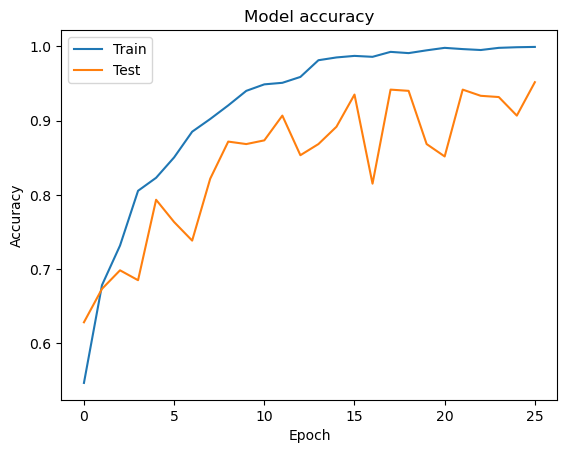

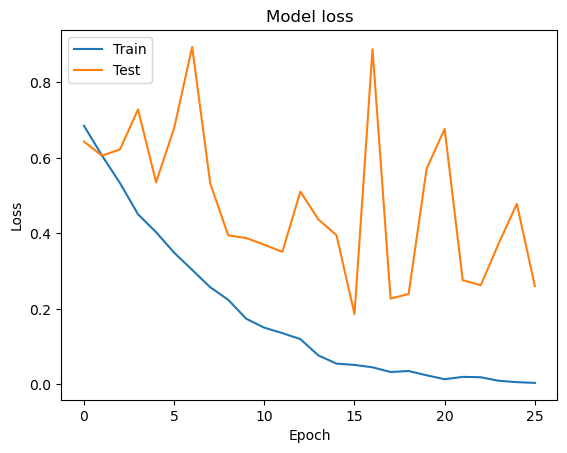

In [157]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [190]:

history = model.fit(
    X_train, y_train,
    batch_size=32,
    verbose=1,
    epochs=100,
    validation_data=(X_test, y_test),
    shuffle=False
)

Epoch 1/100
75/75 [==============================] - 4s 53ms/step - loss: 0.0683 - accuracy: 0.9771 - val_loss: 0.4280 - val_accuracy: 0.8867
Epoch 2/100
75/75 [==============================] - 4s 51ms/step - loss: 0.0730 - accuracy: 0.9733 - val_loss: 0.4527 - val_accuracy: 0.8650
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0558 - accuracy: 0.9808 - val_loss: 0.2380 - val_accuracy: 0.9300
Epoch 4/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0608 - accuracy: 0.9800 - val_loss: 0.3499 - val_accuracy: 0.8883
Epoch 5/100
75/75 [==============================] - 3s 44ms/step - loss: 0.0518 - accuracy: 0.9850 - val_loss: 0.2796 - val_accuracy: 0.9117
Epoch 6/100
75/75 [==============================] - 3s 44ms/step - loss: 0.0488 - accuracy: 0.9867 - val_loss: 0.7778 - val_accuracy: 0.8483
Epoch 7/100
75/75 [==============================] - 3s 44ms/step - loss: 0.0480 - accuracy: 0.9817 - val_loss: 0.3059 - val_accuracy: 0.9267
Epoch 

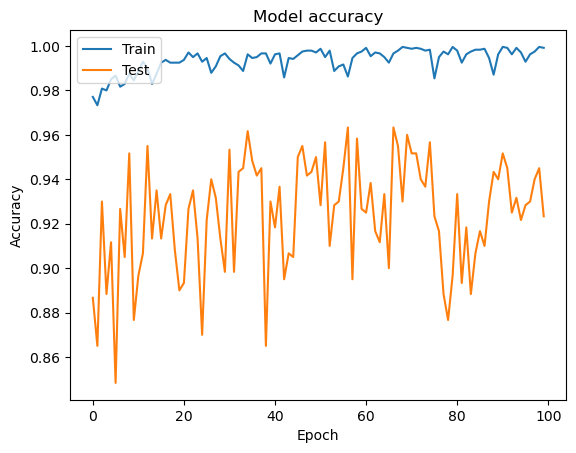

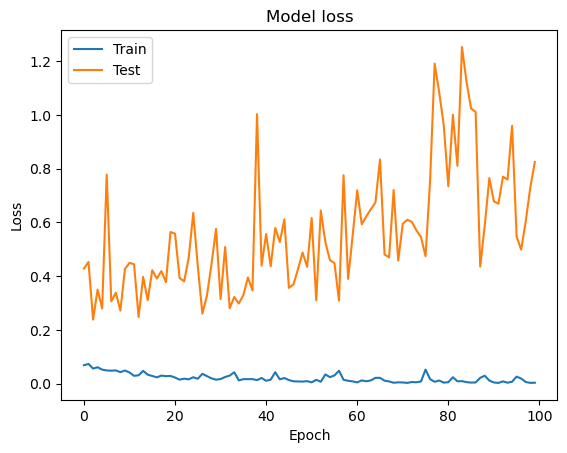

In [192]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
model.save('hello.h5')

C:\Users\MigLovis\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
pwd


'C:\\Users\\MigLovis\\brain_Tumor_Detector-main\\brain_tumor_detection'

In [7]:
model = load_model('C:\\Users\\MigLovis\\brain_Tumor_Detector-main\\brain_tumor_detection\\BrainTumorDetec.h5')

In [8]:
def make_prediction(img):
    input_img = np.expand_dims(img, axis=0)
    
    # Preprocess the input image
    input_img = preprocess_input(input_img)
    
    res = (model.predict(input_img) > 0.5).astype("int32")
    return res


In [12]:
def show_result(img):
    img_path = os.path.join(image_directory, 'pred', img)
    
    # Check if the image file exists
    if os.path.exists(img_path):
        # Read the image using cv2
        image = cv2.imread(img_path)
        
        # Check if the image is successfully read
        if image is not None:
            # Convert the image to an RGB PIL Image
            img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            # Resize the image
            img = img.resize((224, 224))
            
            # Convert the image back to a numpy array if needed
            img = np.array(img)
            
            plt.imshow(img)
            plt.show()
            pred = make_prediction(img)
            if pred:
                print("Tumor Detected")
            else:
                print("No Tumor")

In [14]:
show_result('C:\\Users\\MigLovis\\brain_Tumor_Detector-main\\brain_tumor_detection\\OIP (1).jpg')